In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

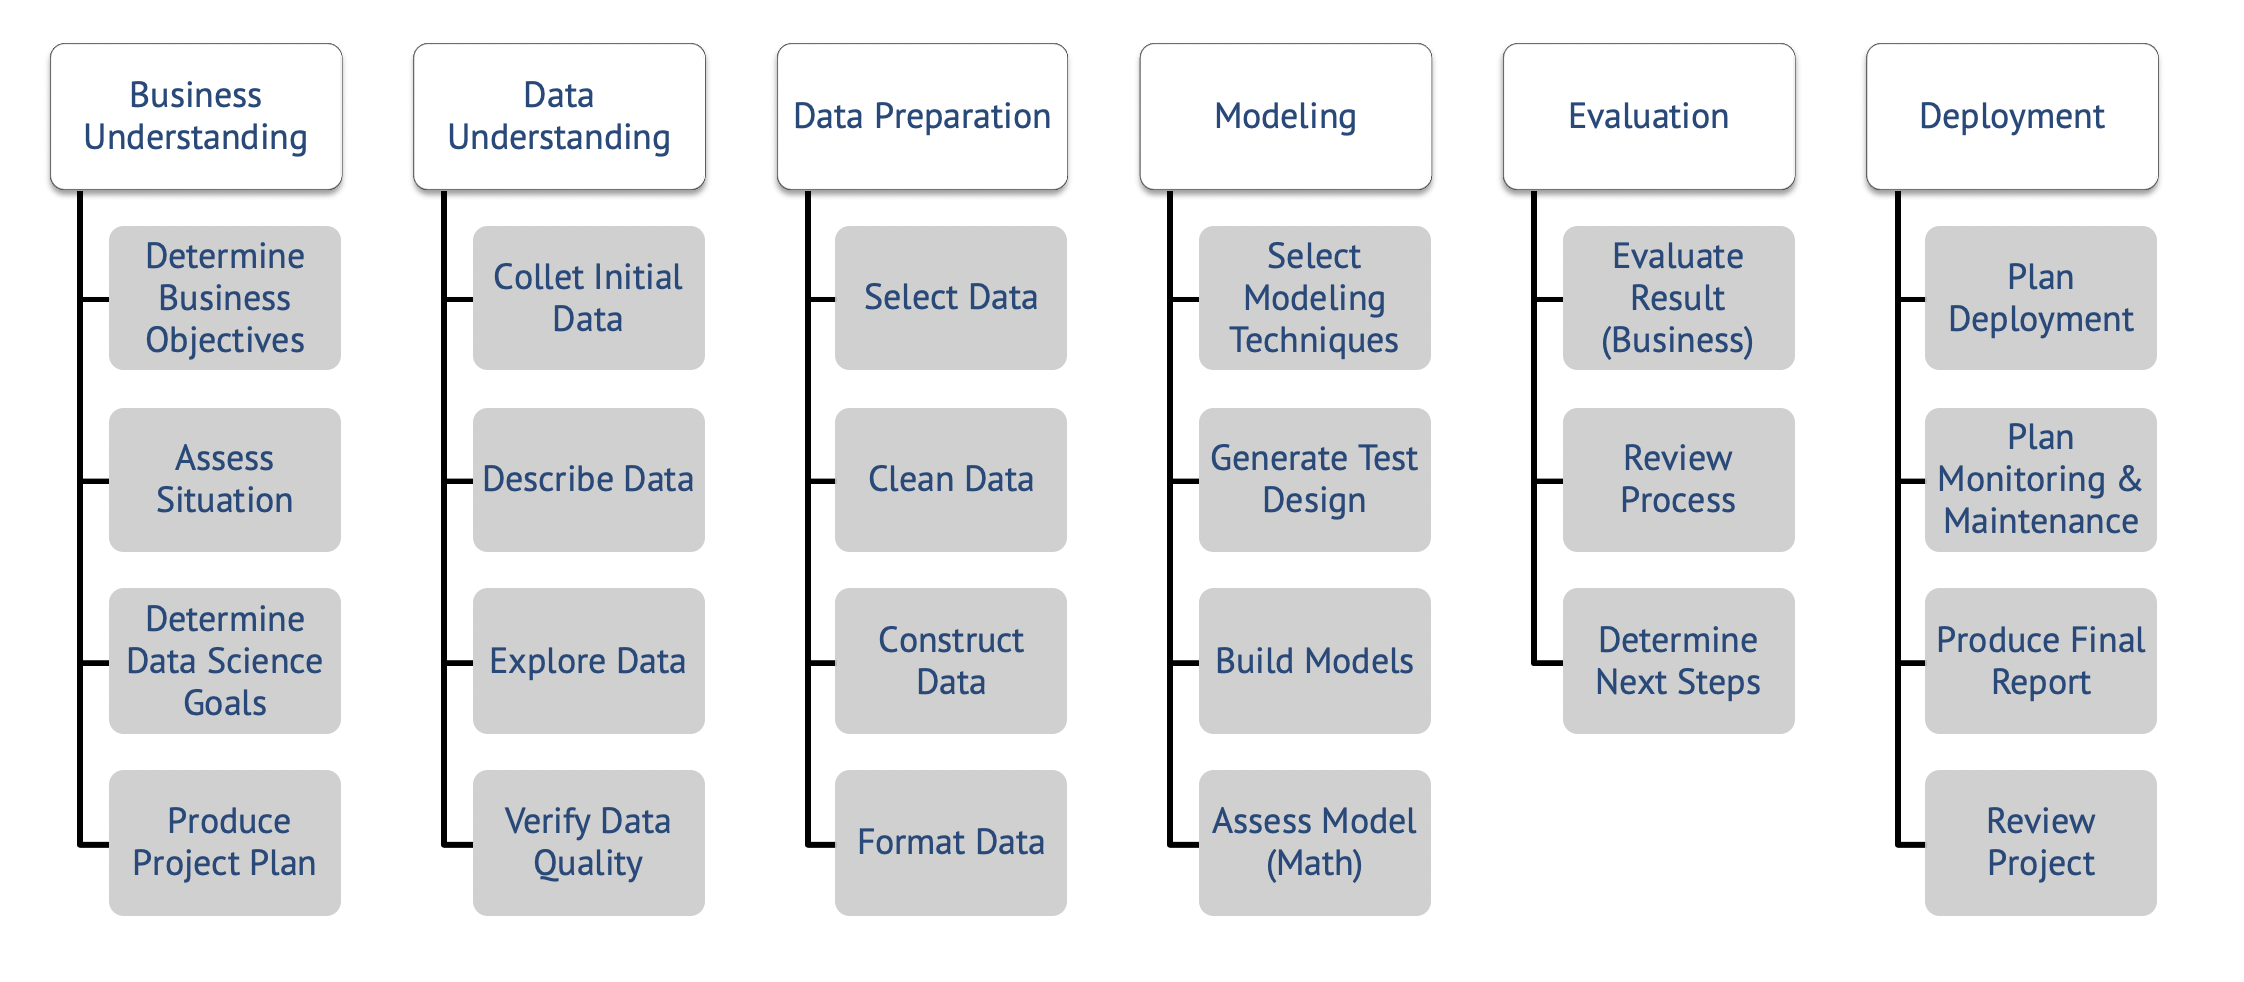

# Data Load

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv(r"S:\Masters\TUK CVT\Data Science\ads_covid-19\data\processed\COVID_small_flat_table.csv",sep=';',
                       parse_dates=[0])  

df_analyse.sort_values('date',ascending=True).tail()

date     Italy        US     Spain   Germany  Korea, South
877 2022-06-17  17809934  86216418  12563399  27204953      18270481
878 2022-06-18  17844905  86230982  12563399  27204955      18276552
879 2022-06-19  17879160  86246101  12563399  27211896      18280090
880 2022-06-20  17896065  86297081  12563399  27334993      18289373
881 2022-06-21  17959329  86452232  12613634  27454225      18298341

# Helper Functions

In [3]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    
    fig.show()
      
      

In [4]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,1:],
           y_scale='linear',
           slider=True)

In [5]:
threshold=100

In [6]:
compare_list=[]
for pos,country in enumerate(df_analyse.columns[1:]):
    compare_list.append(np.array(df_analyse[country][df_analyse[country]>threshold]))

In [7]:
pd_sync_timelines=pd.DataFrame(compare_list,index=df_analyse.columns[1:]).T

In [8]:
 pd_sync_timelines['date']=np.arange(pd_sync_timelines.shape[0])

In [9]:
pd_sync_timelines.head()

Italy     US  Spain  Germany  Korea, South  date
0  155.0  107.0  120.0    117.0         104.0     0
1  229.0  184.0  165.0    150.0         204.0     1
2  322.0  237.0  222.0    188.0         433.0     2
3  453.0  403.0  259.0    240.0         602.0     3
4  655.0  519.0  400.0    349.0         833.0     4

In [10]:
quick_plot(pd_sync_timelines.date,
           pd_sync_timelines.iloc[:,:-1],
           y_scale='log',
           slider=True)

 # Doubling Rate

$N(t)=N_0*2^{t/T}$

In [11]:
def doubling_rate(N_0,t,T_d):
    return N_0*np.power(2,t/T_d)

In [12]:
max_days=34

norm_slopes={
    #'doubling every day':doubling_rate(100,np.arange(10),1),
    'doubling every two days':doubling_rate(100,np.arange(20),2),
    'doubling every 4 days':doubling_rate(100,np.arange(20),4),
    'doubling every 10 days':doubling_rate(100,np.arange(20),10),
}

In [13]:
pd_sync_timelines_w_slope=pd.concat([pd.DataFrame(norm_slopes),pd_sync_timelines], axis=1)

In [16]:
quick_plot(pd_sync_timelines_w_slope.date,
           pd_sync_timelines_w_slope.iloc[:,0:5],
           y_scale='log',
           slider=True)

# Understanding Linear Regression

In [18]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False)

In [19]:
l_vec=len(df_analyse['Germany'])
X=np.arange(l_vec-5).reshape(-1, 1)
y=np.log(np.array(df_analyse['Germany'][5:]))

In [20]:
reg.fit(X,y)

LinearRegression(fit_intercept=False)

In [21]:
X_hat=np.arange(l_vec).reshape(-1, 1)
Y_hat=reg.predict(X_hat)

In [22]:
LR_inspect=df_analyse[['date','Germany']].copy()

In [23]:
LR_inspect['prediction']=np.exp(Y_hat)

In [24]:
quick_plot(LR_inspect.date,
           LR_inspect.iloc[:,1:],
           y_scale='log',
           slider=True)

# Doubling Rate - Piecewise Linear Regression

In [25]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)

In [26]:
from scipy import signal

In [27]:
df_analyse=pd.read_csv(r"S:\Masters\TUK CVT\Data Science\ads_covid-19\data\processed\COVID_small_flat_table.csv",sep=';',
                       parse_dates=[0])  
country_list=df_analyse.columns[1:]

In [28]:
## filter data
for each in country_list:
    df_analyse[each+'_filter']=signal.savgol_filter(df_analyse[each],
                           5, # window size used for filtering
                           1) # order of fitted polynomial

In [29]:
filter_cols=['Italy_filter','US_filter', 'Spain_filter', 'Germany_filter']

In [30]:
start_pos=5
quick_plot(df_analyse.date[start_pos:],
           df_analyse[filter_cols].iloc[start_pos:,:], #['US','US_filter']
           y_scale='log',
           slider=True)

In [31]:
df_analyse.head()

date  Italy  US  Spain  Germany  Korea, South  Italy_filter  \
0 2020-01-22      0   1      0        0             1           0.0   
1 2020-01-23      0   1      0        0             1           0.0   
2 2020-01-24      0   2      0        0             2           0.0   
3 2020-01-25      0   2      0        0             2           0.0   
4 2020-01-26      0   5      0        0             3           0.0   

   US_filter  Spain_filter  Germany_filter  Korea, South_filter  
0        0.4           0.0             0.0                  0.8  
1        1.3           0.0             0.0                  1.3  
2        2.2           0.0             0.0                  1.8  
3        3.0           0.0             0.2                  2.4  
4        3.8           0.0             1.0                  3.0

In [32]:
def get_doubling_time_via_regression(in_array):
    ''' Use a linear regression to approximate the doubling rate'''
    
    y = np.array(in_array)
    X = np.arange(-1,2).reshape(-1, 1)
    
    assert len(in_array)==3
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_
    
    return intercept/slope

In [33]:
def doubling_time(in_array):
    ''' Use a classical doubling time formular, 
     see https://en.wikipedia.org/wiki/Doubling_time '''
    y = np.array(in_array)
    return len(y)*np.log(2)/np.log(y[-1]/y[0])

In [34]:
# calculate slope of regression of last x days
# use always a limited number of days to approximate the triangle, attention exponential base assumption
days_back = 3 # this gives a smoothing effect
for pos,country in enumerate(country_list):
    df_analyse[country+'_DR']=df_analyse[country].rolling(
                                window=days_back,
                                min_periods=days_back).apply(get_doubling_time_via_regression, raw=False)

In [35]:
# run on all filtered data
days_back = 3 # this gives a smoothing effect
for pos,country in enumerate(filter_cols):
    df_analyse[country+'_DR']=df_analyse[country].rolling(
                                window=days_back,
                                min_periods=days_back).apply(get_doubling_time_via_regression, raw=False)

In [36]:
# cross check the matematical 
df_analyse['Germany_DR_math']=df_analyse['Germany'].rolling(
                                window=days_back,
                                min_periods=days_back).apply(doubling_time, raw=False)

In [37]:
# run on all filtered data
days_back = 3 # this gives a smoothing effect
for pos,country in enumerate(filter_cols):
    df_analyse[country+'_DR']=df_analyse[country].rolling(
                                window=days_back,
                                min_periods=days_back).apply(get_doubling_time_via_regression, raw=False)

In [38]:
df_analyse.columns

Index(['date', 'Italy', 'US', 'Spain', 'Germany', 'Korea, South',
       'Italy_filter', 'US_filter', 'Spain_filter', 'Germany_filter',
       'Korea, South_filter', 'Italy_DR', 'US_DR', 'Spain_DR', 'Germany_DR',
       'Korea, South_DR', 'Italy_filter_DR', 'US_filter_DR', 'Spain_filter_DR',
       'Germany_filter_DR', 'Germany_DR_math'],
      dtype='object')

In [39]:
start_pos=40
quick_plot(df_analyse.date[start_pos:],
           df_analyse.iloc[start_pos:,[11,12,13,14]], #
           y_scale='linear',
           slider=True)

In [40]:
start_pos=40
quick_plot(df_analyse.date[start_pos:],
           df_analyse.iloc[start_pos:,[16,17,18,19]], #17,18,19   # US comparison 12,17
           y_scale='linear',
           slider=True)